In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn import linear_model

In [2]:
fig_size_1 = (12, 4)
fig_size_2 = (6, 3)
fig_size_3 = (6, 6)
today = datetime.today().strftime('%Y-%m-%d')
start_date = '1970-01-02'
end_date = today
three_months = (datetime.today()-relativedelta(months=3)).strftime('%Y-%m-%d')
six_months = (datetime.today()-relativedelta(months=6)).strftime('%Y-%m-%d')
one_year = (datetime.today()-relativedelta(years=1)).strftime('%Y-%m-%d')

In [3]:
tickers = ['AMZN', 'AAPL', 'FB', 'GOOGL', 'MSFT', 'UBER',
           'XOM', 'BA', 'DAL', 'UAL', 'AAL',
           'SMH', 'XLE', 'IVV', 'VNQ', 'VCSH']

num_shares = {'AMZN': 17, 'AAPL': 208, 'FB': 74, 'GOOGL': 10, 'MSFT': 87, 'UBER': 554,
              'XOM': 361, 'BA': 87, 'DAL': 141, 'UAL': 129, 'AAL': 316,
              'SMH': 57, 'XLE': 431, 'IVV': 64, 'VNQ': 118, 'VCSH': 384, 'CASH': 108443}

cost_basis = {'AMZN': 1708.54, 'AAPL': 45.57, 'FB': 168.62, 'GOOGL': 1110.79, 'MSFT': 95.20, 'UBER': 21.65,
              'XOM': 41.51, 'BA': 137.98, 'DAL': 23.61, 'UAL': 25.73, 'AAL': 10.54,
              'SMH': 110.00, 'XLE': 30.12, 'IVV': 267.39, 'VNQ': 76.10, 'VCSH': 78.07, 'CASH': 1}

asset_type = {'AMZN': 'Stock', 'AAPL': 'Stock', 'FB': 'Stock', 'GOOGL': 'Stock', 'MSFT': 'Stock', 'UBER': 'Stock',
              'XOM': 'Stock', 'BA': 'Stock', 'DAL': 'Stock', 'UAL': 'Stock', 'AAL': 'Stock',
              'SMH': 'ETF', 'XLE': 'ETF', 'IVV': 'Index', 'VNQ': 'REIT', 'VCSH': 'Bond', 'CASH': 'Cash'}

In [4]:
df = pd.DataFrame()

for ticker in tickers:
    df_temp = data.DataReader(ticker, 'yahoo', start_date, end_date).reset_index()[['Date', 'Close']]
    df_temp['Ticker'] = [ticker] * len(df_temp)
    df_temp['Shares'] = [num_shares[ticker]] * len(df_temp)
    df_temp['Type'] = [asset_type[ticker]] * len(df_temp)
    df_temp['Cost'] = [cost_basis[ticker]] * len(df_temp)
    df = df.append(df_temp)

df = df.append({'Ticker': 'CASH', 'Date' : df['Date'].max() , 'Close' : 1, 'Shares': num_shares['CASH'],
                'Type': asset_type['CASH'], 'Cost': cost_basis['CASH']}, ignore_index=True)

df['Mkt Val'] = df['Shares'] * df['Close']
df['Cost Basis'] = df['Shares'] * df['Cost']
df['Change'] = df['Mkt Val'] - df['Cost Basis']
df['Change %'] = 100*df['Change']/df['Cost Basis']

df_final = df.groupby(['Ticker']).tail(1).set_index('Ticker')
df_final['Mkt Val %'] = 100*df_final['Mkt Val']/df_final['Mkt Val'].sum()
df_final['Cost Basis %'] = 100*df_final['Cost Basis']/df_final['Cost Basis'].sum()
df_final

,Date,Close,Shares,Type,Cost,Mkt Val,Cost Basis,Change,Change %,Mkt Val %,Cost Basis %
Ticker,,,,,,,,,,,
AMZN,2020-11-18,3105.459961,17,Stock,1708.54,52792.819336,29045.18,23747.639336,81.761033,13.004127,9.582055
AAPL,2020-11-18,118.029999,208,Stock,45.57,24550.239746,9478.56,15071.679746,159.008117,6.047308,3.126993
FB,2020-11-18,271.970001,74,Stock,168.62,20125.780090,12477.88,7647.900090,61.291662,4.957458,4.116474
GOOGL,2020-11-18,1740.640015,10,Stock,1110.79,17406.400146,11107.90,6298.500146,56.702888,4.287610,3.664515
MSFT,2020-11-18,211.080002,87,Stock,95.20,18363.960159,8282.40,10081.560159,121.722691,4.523480,2.732378
UBER,2020-11-18,49.110001,554,Stock,21.65,27206.940338,11994.10,15212.840338,126.836031,6.701717,3.956874
XOM,2020-11-18,37.209999,361,Stock,41.51,13432.809669,14985.11,-1552.300331,-10.358952,3.308821,4.943614
BA,2020-11-18,203.300003,87,Stock,137.98,17687.100266,12004.26,5682.840266,47.340196,4.356754,3.960226
DAL,2020-11-18,37.910000,141,Stock,23.61,5345.309978,3329.01,2016.299978,60.567555,1.316677,1.098246


<AxesSubplot:title={'center':'Change'}, xlabel='Ticker'>

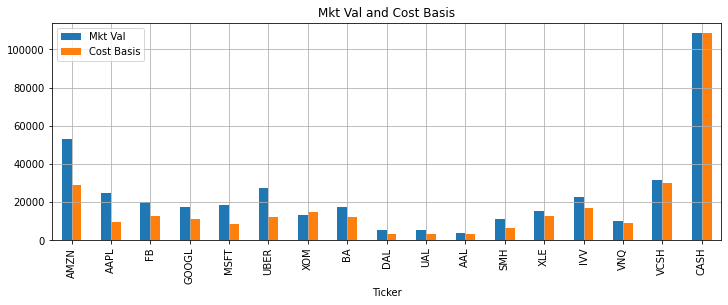

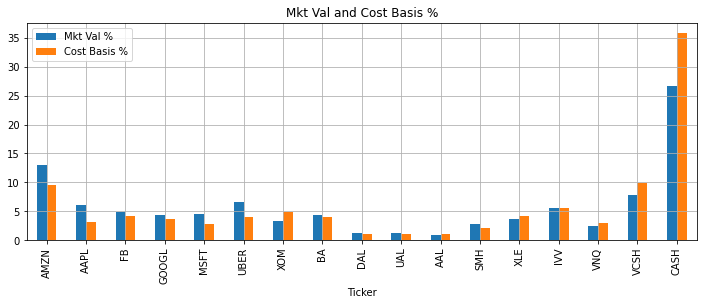

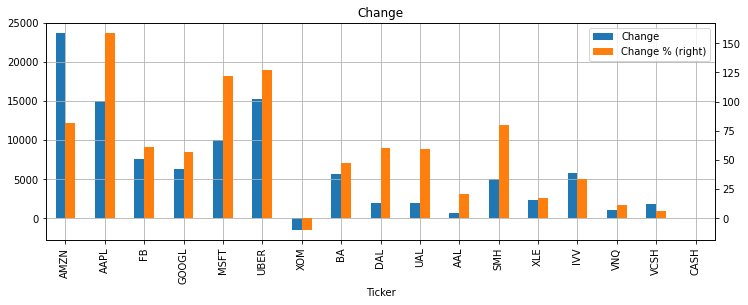

In [5]:
df_final.plot(y=['Mkt Val', 'Cost Basis'], kind='bar',
                   figsize=fig_size_1, grid=True, title='Mkt Val and Cost Basis')
df_final.plot(y=['Mkt Val %', 'Cost Basis %'], kind='bar',
                   figsize=fig_size_1, grid=True, title='Mkt Val and Cost Basis %')
df_final.plot(y=['Change', 'Change %'], secondary_y='Change %', kind='bar',
                   figsize=fig_size_1, grid=True, title='Change')

In [6]:
df_final_type = df_final.groupby('Type').sum()[['Mkt Val', 'Cost Basis']]
df_final_type['Mkt Val %'] = 100*df_final_type['Mkt Val']/df_final_type['Mkt Val'].sum()
df_final_type['Cost Basis %'] = 100*df_final_type['Cost Basis']/df_final_type['Cost Basis'].sum()
df_final_type['Change'] = df_final_type['Mkt Val'] - df_final_type['Cost Basis']
df_final_type['Change %'] = 100 * df_final_type['Change'] / df_final_type['Cost Basis']
df_final_type

,Mkt Val,Cost Basis,Mkt Val %,Cost Basis %,Change,Change %
Type,,,,,,
Bond,31833.600586,29978.88,7.841373,9.890084,1854.720586,6.186757
Cash,108443.000000,108443.00,26.712091,35.775533,0.000000,0.000000
ETF,26575.389420,19251.72,6.546151,6.351176,7323.669420,38.041637
Index,22885.759766,17112.96,5.637307,5.645595,5772.799766,33.733497
REIT,9999.319748,8979.80,2.463070,2.962452,1019.519748,11.353479
Stock,206232.649559,119354.21,50.800008,39.375160,86878.439559,72.790427


<AxesSubplot:title={'center':'Change %'}, xlabel='Type'>

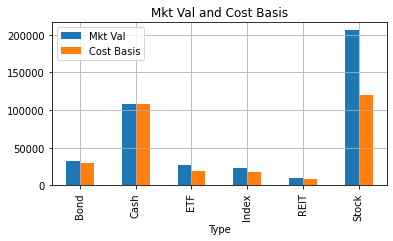

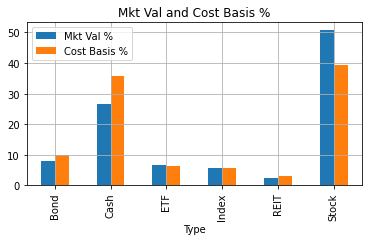

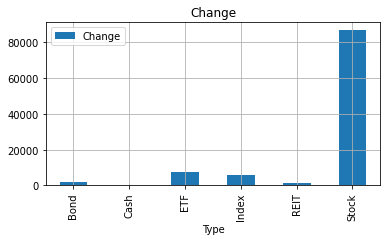

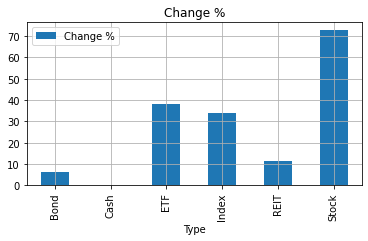

In [7]:
df_final_type.plot(y=['Mkt Val', 'Cost Basis'], kind='bar',
                   figsize=fig_size_2, grid=True, title='Mkt Val and Cost Basis')
df_final_type.plot(y=['Mkt Val %', 'Cost Basis %'], kind='bar',
                   figsize=fig_size_2, grid=True, title='Mkt Val and Cost Basis %')
df_final_type.plot(y='Change', kind='bar',
                   figsize=fig_size_2, grid=True, title='Change')
df_final_type.plot(y='Change %', kind='bar',
                   figsize=fig_size_2, grid=True, title='Change %')

In [8]:
period = three_months

mkt_val = (df[df['Ticker'] != 'CASH'].groupby('Date').sum()['Mkt Val']) + df[df['Ticker'] == 'CASH'][['Mkt Val']].values[0]
mkt_val = mkt_val.reset_index()

dff = mkt_val[(mkt_val['Date'] >= period) & (mkt_val['Date'] <= end_date)].set_index('Date')
dff['% Chg Portfolio'] = 100*(dff['Mkt Val']-dff.head(1)['Mkt Val'].values[0])/dff.head(1)['Mkt Val'].values[0]
dff['Close IVV'] = df[(df['Ticker'] == 'IVV') & (df['Date'] >= period) & (df['Date'] <= end_date)][['Date', 'Close']].set_index('Date')
dff['% Chg IVV'] = 100*(dff['Close IVV']-dff.head(1)['Close IVV'].values[0])/dff.head(1)['Close IVV'].values[0]

model = linear_model.LinearRegression()
model.fit(np.array(dff[['% Chg IVV']]), np.array(dff[['% Chg Portfolio']]))
dff['% Chg Pred'] = model.predict(np.array(dff[['% Chg IVV']]))

dff

,Mkt Val,% Chg Portfolio,Close IVV,% Chg IVV,% Chg Pred
Date,,,,,
2020-08-19,388254.469908,0.000000,338.619995,0.000000,-0.589666
2020-08-20,391172.222738,0.751505,339.660004,0.307131,-0.338431
2020-08-21,391107.139866,0.734742,340.850006,0.658559,-0.050962
2020-08-24,395746.813175,1.929751,344.350006,1.692166,0.794532
2020-08-25,396416.309607,2.102188,345.489990,2.028821,1.069918
...,...,...,...,...,...
2020-11-12,399173.237736,2.812271,354.519989,4.695527,3.251293
2020-11-13,403882.602173,4.025229,359.339996,6.118954,4.415661
2020-11-16,409677.679520,5.517827,363.799988,7.436062,5.493060


Beta: [0.81800364]


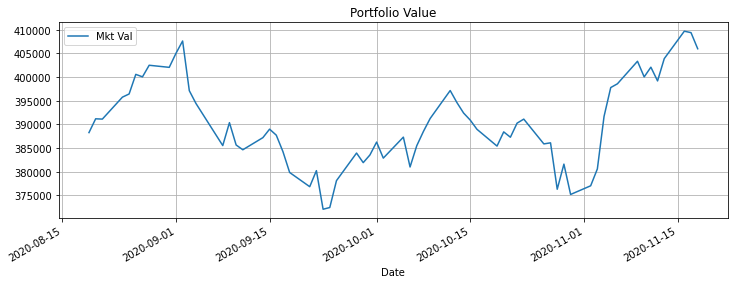

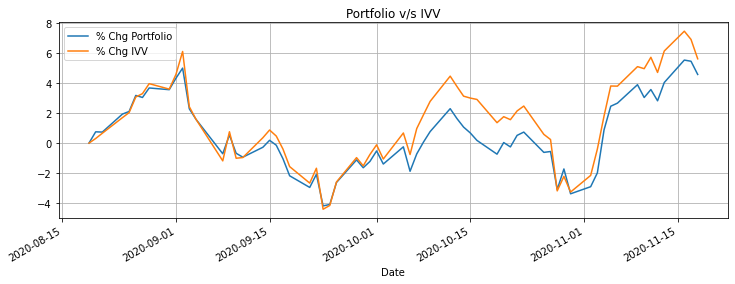

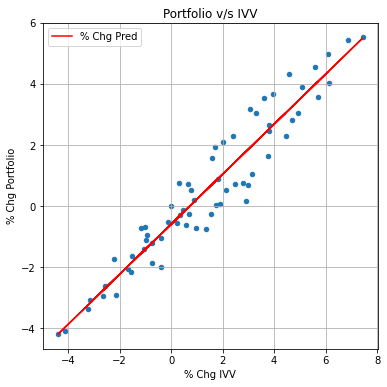

In [9]:
mkt_val[(mkt_val['Date'] >= period) & (mkt_val['Date'] <= end_date)].plot(
    x='Date', y=['Mkt Val'],
    figsize=fig_size_1, grid=True, title='Portfolio Value')

dff.plot(y=['% Chg Portfolio', '% Chg IVV'], figsize=fig_size_1, grid=True, title='Portfolio v/s IVV')

fig, axes = plt.subplots(sharex=True)
dff.plot(x='% Chg IVV', y='% Chg Portfolio', kind='scatter',
         ax=axes, figsize=fig_size_3, grid=True, title='Portfolio v/s IVV')
dff.plot(x='% Chg IVV', y='% Chg Pred', kind='line', color='Red',
         ax=axes, figsize=fig_size_3, grid=True, title='Portfolio v/s IVV')

print('Beta:', model.coef_[0])